In [1187]:
import torch
import math
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [1188]:
device = torch.device('cpu')

In [1189]:
names = open('names.txt', 'r').read().splitlines()
print(f"Total Names: {len(names)}", *names[:5], "...", sep=", ")

Total Names: 32033, emma, olivia, ava, isabella, sophia, ...


In [1190]:
ctoi = {c:i for i, c in enumerate(['.'] + sorted(list(set(''.join(names)))))}
itoc = {i:c for c, i in ctoi.items()}

In [1191]:
block_size = 3

In [1192]:
def build_dataset(words, block_size=block_size):
    X = []
    Y = []
    for word in words:
        context = [0] * block_size
        for c in word + '.':
            ci = ctoi[c]
            X.append(context)
            Y.append(ci)
            # print(''.join(itoc[c] for c in context) + ' ---> ' + itoc[ci])
            context = context[1:] + [ci]

    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y


In [1193]:
X, Y = build_dataset(names, block_size=block_size)

In [1194]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [1195]:
trnProp = 0.8
valProp = 0.1

n1 = int(trnProp*len(names))
n2 = int((trnProp + valProp)*len(names))

random.shuffle(names)

Xtrn, Ytrn = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xtst, Ytst = build_dataset(names[n2:])

In [1196]:
Ytrn.shape, Ydev.shape, Ytst.shape

(torch.Size([182364]), torch.Size([22881]), torch.Size([22901]))

In [1197]:
dims = 15
hidden_layer = 150

In [1198]:
g = torch.Generator(device=device).manual_seed(0)
C = torch.randn((27, dims), generator=g, device=device)

W1 = torch.randn((dims*block_size, hidden_layer), generator=g, device=device)
b1 = torch.randn(hidden_layer, generator=g, device=device)

W2 = torch.randn((hidden_layer, 27), generator=g, device=device)
b2 = torch.randn(27, generator=g, device=device)

parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters)

11382

In [1199]:
for p in parameters:
    p.requires_grad = True

In [1200]:
losstrn = []

In [1201]:
def getloss(X, Y):
    emb = C[X]
    h = torch.tanh(emb.view((-1, block_size*dims)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss

In [1209]:
nitr = 600000
lrs = torch.linspace(0.1**0.33, 0.005**0.33, nitr)**3
for g in range(nitr):
    # batching
    ix = torch.randint(0, Xtrn.shape[0], (64,))
    # forward pass
    emb = C[Xtrn[ix]]
    h = torch.tanh(emb.view((-1, block_size*dims)) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytrn[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = lrs[g]
    for p in parameters:
        p.data += -lr * p.grad
    # stats
    losstrn.append(loss)


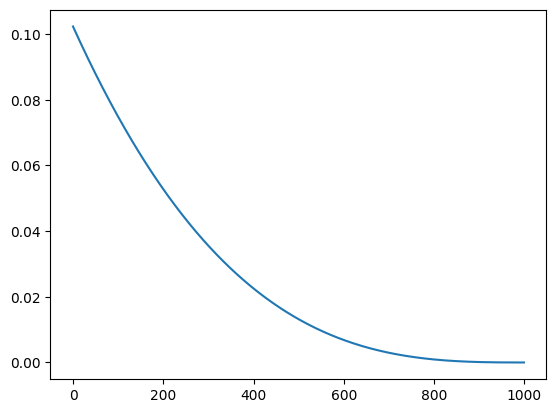

In [1203]:
plt.plot(torch.linspace(0.1**0.33, 0.005, 1000)**3)

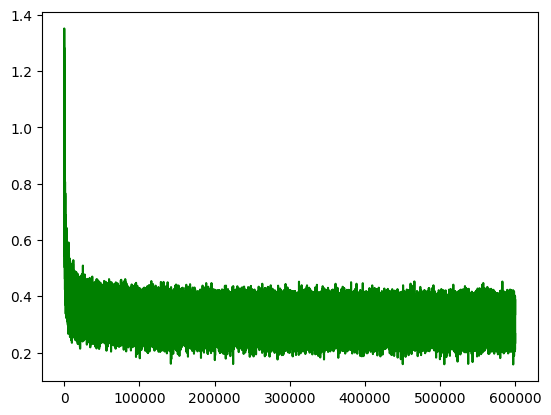

In [1210]:
plt.plot(list(map(lambda x: x.log10().item(), losstrn)), color='green')


In [1211]:
getloss(Xtrn, Ytrn).item(), getloss(Xdev, Ydev).item(), getloss(Xtst, Ytst).item()

(2.0744147300720215, 2.130159616470337, 2.12939453125)

In [1249]:
def generate():
    op = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # print(probs)
        nxti = torch.multinomial(probs, num_samples=1).item()
        if nxti == 0: return ''.join([itoc[x] for x in op])
        context = context[1:] + [nxti]
        op.append(nxti)

generate()

'moelliemariliah'